# Bitcoin Confluence Notebook
Load the cached Binance data, recompute the confluence signals, and visualise entries/exits alongside the equity curve.

In [7]:
# BitcoinConfluence.py
# deps: pip install -U pandas numpy scipy matplotlib

import math
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

warnings.filterwarnings("ignore")

# ----------------- Parameters -----------------
START  = "2017-01-01"     # earliest date we attempt to load from cached Binance data
END    = None
SPLIT  = "2021-01-01"     # In-sample / Out-of-sample split (edit as you like)

CTX    = 250              # bars for volume profile (≈ 1y of daily bars)
VA_PCT = 0.70             # value area percent

FEE    = 0.0005           # fee per side
SLIP   = 0.0005           # slippage per side
COST   = FEE + SLIP

SWING_WIN   = 60          # days to detect last swing high/low
ATR_WIN     = 14
ENTRY_SCORE = 2           # confluence needed to enter (sum of booleans)
ATR_STOP_MULT = 1.5       # stop distance in ATR if structural stop not available

if "__file__" in globals():
    _BASE_DIR = Path(__file__).resolve().parent
else:
    _BASE_DIR = Path.cwd()
DATA_DIR = _BASE_DIR / "data"


# ----------------- Data -----------------
def fetch_binance_daily(symbols: list[str]) -> pd.DataFrame:
    """
    Load daily OHLCV from cached CSVs produced by fetch_binance_top10.py.
    Returns DataFrame with MultiIndex columns: (symbol, field).
    """
    frames: list[pd.DataFrame] = []
    for sym in symbols:
        csv_name = sym.replace("/", "") + ".csv"
        path = DATA_DIR / csv_name
        if not path.exists():
            raise FileNotFoundError(f"Cached data not found for {sym}. Expected file: {path}")
        df = pd.read_csv(path, parse_dates=["open_time"])
        df = df.rename(columns=str.lower)
        df.set_index("open_time", inplace=True)
        if getattr(df.index, "tz", None) is not None:
            df.index = df.index.tz_convert("UTC").tz_localize(None)
        df = df[["open", "high", "low", "close", "volume"]].astype(float)
        df.columns = pd.MultiIndex.from_product([[sym], df.columns])
        frames.append(df)
        print(f"[cache] Loaded {sym} from {path}")

    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, axis=1).sort_index()

def pick_btc_symbol(exframe: pd.DataFrame) -> str:
    """Prefer USD perp; else USD spot; else USDT."""
    candidates = ["BTC/USDT", "BTC/BUSD", "BTC/USDC", "BTC/FDUSD"]
    for c in candidates:
        if (c, "close") in exframe.columns:
            return c
    # fallback to any BTC/* we found
    symbols = list({c[0] for c in exframe.columns})
    for s in symbols:
        if s.startswith("BTC/"):
            return s
    raise RuntimeError("No BTC symbols found in Binance data.")

# ----------------- Indicators -----------------
def rolling_atr(df: pd.DataFrame, win: int = ATR_WIN) -> pd.Series:
    """Pandas-native ATR (no numpy arrays)."""
    high, low, close = df["high"], df["low"], df["close"]
    tr = pd.concat([
        (high - low),
        (high - close.shift()).abs(),
        (low  - close.shift()).abs(),
    ], axis=1).max(axis=1)
    return tr.rolling(win, min_periods=1).mean()

def volume_profile(ctx_close: pd.Series, ctx_vol: pd.Series, bins: int = CTX, va_pct: float = VA_PCT):
    """
    Simple close-price/volume histogram profile over context window.
    Returns POC, VAL, VAH, centers, hist.
    """
    lo, hi = ctx_close.min(), ctx_close.max()
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        centers = np.array([float(lo)])
        hist = np.array([float(ctx_vol.sum())])
        poc_px = float(lo)
        return poc_px, np.nan, np.nan, centers, hist

    edges = np.linspace(lo, hi, bins + 1)
    hist, edges = np.histogram(ctx_close.values, bins=edges, weights=ctx_vol.values)
    centers = (edges[:-1] + edges[1:]) / 2.0

    if hist.sum() <= 0:
        return float(centers[0]), np.nan, np.nan, centers, hist

    poc_px = float(centers[hist.argmax()])

    # build symmetric VA around POC covering va_pct of volume
    idx = int(hist.argmax())
    L = R = idx
    cum = hist[idx]
    total = hist.sum()
    while cum < va_pct * total and (L > 0 or R < len(hist) - 1):
        left = hist[L - 1] if L > 0 else -np.inf
        right = hist[R + 1] if R < len(hist) - 1 else -np.inf
        if right >= left:
            R += 1; cum += hist[R]
        else:
            L -= 1; cum += hist[L]
    VAL = float(centers[L])
    VAH = float(centers[R])
    return poc_px, VAL, VAH, centers, hist

def detect_npocs(poc: pd.Series, high: pd.Series, low: pd.Series, ref_close: pd.Series) -> tuple[pd.Series, pd.Series]:
    """
    NPOCs using daily bars:
      - Yesterday's POC becomes 'open' from today.
      - Remove an open POC as soon as today's [low, high] trades through it.
      - For each day, return nearest open NPOC strictly above/below today's **close**.
    """
    idx = poc.index
    open_levels: list[float] = []
    npoc_above = np.full(len(idx), np.nan, dtype=float)
    npoc_below = np.full(len(idx), np.nan, dtype=float)

    prev_p = np.nan
    for i in range(len(idx)):
        lo = float(low.iloc[i]); hi = float(high.iloc[i]); c = float(ref_close.iloc[i])

        # remove filled levels
        if open_levels:
            open_levels = [lvl for lvl in open_levels if not (lo <= lvl <= hi)]

        # add yesterday's poc
        if np.isfinite(prev_p):
            open_levels.append(float(prev_p))

        # record nearest above/below
        if open_levels:
            above = [lvl for lvl in open_levels if lvl > c]
            below = [lvl for lvl in open_levels if lvl < c]
            npoc_above[i] = min(above) if above else np.nan
            npoc_below[i] = max(below) if below else np.nan
        else:
            npoc_above[i] = np.nan
            npoc_below[i] = np.nan

        # store today's poc for tomorrow
        prev_p = float(poc.iloc[i]) if np.isfinite(poc.iloc[i]) else np.nan

    return pd.Series(npoc_above, index=idx, name="npoc_above"), pd.Series(npoc_below, index=idx, name="npoc_below")

def last_swings(df: pd.DataFrame, win: int = SWING_WIN) -> tuple[int, int]:
    """Indices of last swing low and last swing high using local extrema."""
    h = df["high"].values; l = df["low"].values
    highs = argrelextrema(h, np.greater_equal, order=win)[0]
    lows  = argrelextrema(l, np.less_equal,   order=win)[0]
    hi_idx = int(highs[-1]) if len(highs) else int(np.argmax(h))
    lo_idx = int(lows[-1])  if len(lows)  else int(np.argmin(l))
    return lo_idx, hi_idx

def anchored_vwap(close: pd.Series, vol: pd.Series, anchor_idx: int) -> pd.Series:
    """AVWAP anchored at anchor_idx (inclusive)."""
    pv = (close * vol).copy()
    v  = vol.copy()
    pv.iloc[:anchor_idx] = 0.0
    v.iloc[:anchor_idx] = 0.0
    vw = pv.cumsum() / v.cumsum()
    vw.iloc[:anchor_idx] = np.nan
    return vw

def golden_pocket_from_swing(lo_px: float, hi_px: float, uptrend: bool) -> tuple[float, float]:
    """Return (gp_low, gp_high) bounds for the 61.8–65% retracement."""
    hi, lo = (hi_px, lo_px)
    span = hi - lo
    if uptrend:
        # pullback in uptrend measured from hi → lo
        gp_low  = hi - 0.65 * span
        gp_high = hi - 0.618 * span
    else:
        gp_low  = lo + 0.618 * span
        gp_high = lo + 0.65  * span
    return float(min(gp_low, gp_high)), float(max(gp_low, gp_high))

# ----------------- Build feature set -----------------
def build_btc_frame() -> pd.DataFrame:
    # try Binance USD spot variations (only those cached locally)
    preferred = ["BTC/USDT", "BTC/BUSD", "BTC/USDC", "BTC/FDUSD"]
    available = [s for s in preferred if (DATA_DIR / (s.replace("/", "") + ".csv")).exists()]
    if not available:
        raise RuntimeError("No cached Binance data found for BTC. Run fetch_binance_top10.py first.")
    binance = fetch_binance_daily(available)
    if binance.empty:
        raise RuntimeError("Cached Binance data for BTC returned empty frame.")
    sym = pick_btc_symbol(binance)
    df = binance[sym].copy()
    df = df.loc[df.index >= pd.Timestamp(START)]
    if END:
        df = df.loc[df.index <= pd.Timestamp(END)]
    df = df.rename(columns=str)  # ensure 'open','high','low','close','volume' as strings

    # Ensure correct column order
    df = df[["open", "high", "low", "close", "volume"]].astype(float)

    # ATR
    df["atr"] = rolling_atr(df, ATR_WIN)

    # Rolling volume profile POC/VAL/VAH
    poc, val, vah = [], [], []
    for i in range(len(df)):
        j0 = max(0, i - CTX + 1)
        ctx = df.iloc[j0:i+1]
        p_, vL_, vH_, _, _ = volume_profile(ctx["close"], ctx["volume"], bins=CTX, va_pct=VA_PCT)
        poc.append(p_); val.append(vL_); vah.append(vH_)
    df["poc"], df["val"], df["vah"] = poc, val, vah

    # NPOCs (use close as reference for "nearest above/below")
    npoc_up, npoc_dn = detect_npocs(df["poc"], df["high"], df["low"], df["close"])
    df["npoc_above"], df["npoc_below"] = npoc_up, npoc_dn

    # Swings & Anchored VWAPs
    lo_i, hi_i = last_swings(df, SWING_WIN)
    df["avwap_from_lo"] = anchored_vwap(df["close"], df["volume"], lo_i)
    df["avwap_from_hi"] = anchored_vwap(df["close"], df["volume"], hi_i)

    # Golden pocket
    lo_px, hi_px = float(df.iloc[lo_i]["low"]), float(df.iloc[hi_i]["high"])
    uptrend = hi_i > lo_i
    gp_low, gp_high = golden_pocket_from_swing(lo_px, hi_px, uptrend)
    df["gp_low"], df["gp_high"], df["swing_dir"] = gp_low, gp_high, (1 if uptrend else -1)

    # Daily prev levels
    d_prev = df.shift(1)
    df["y_high"], df["y_low"], df["y_open"] = d_prev["high"], d_prev["low"], d_prev["open"]

    # Weekly (Fri close week)
    wk = df.resample("W-FRI").agg({"open":"first","high":"max","low":"min","close":"last"})
    for col in ["open","high","low","close"]:
        df[f"w_{col}"] = wk[col].shift().reindex(df.index).ffill()

    # Monthly (month-end)
    mo = df.resample("M").agg({"open":"first","high":"max","low":"min","close":"last"})
    for col in ["open","high","low","close"]:
        df[f"m_{col}"] = mo[col].shift().reindex(df.index).ffill()

    # Drop earliest rows until ATR exists
    return df.dropna(subset=["atr"])

# ----------------- Signals (confluence) -----------------
def confluence_signals(df: pd.DataFrame, tol: float = 0.003) -> pd.DataFrame:
    s = pd.DataFrame(index=df.index)

    # NPOC touch & reject
    s["touch_npoc_long"]  = df["npoc_below"].notna() & (df["low"]  <= df["npoc_below"]*(1+tol)) & (df["close"] > df["npoc_below"])
    s["touch_npoc_short"] = df["npoc_above"].notna() & (df["high"] >= df["npoc_above"]*(1-tol)) & (df["close"] < df["npoc_above"])

    # AVWAP support/resistance
    s["avwap_support"] = df["avwap_from_lo"].notna() & (df["low"]  <= df["avwap_from_lo"]*(1+tol)) & (df["close"] > df["avwap_from_lo"])
    s["avwap_resist"]  = df["avwap_from_hi"].notna() & (df["high"] >= df["avwap_from_hi"]*(1-tol)) & (df["close"] < df["avwap_from_hi"])

    # Value area re-entries
    s["reenter_value_long"]  = df["val"].notna() & (df["close"].shift(1) < df["val"].shift(1)) & (df["close"] > df["val"])
    s["reenter_value_short"] = df["vah"].notna() & (df["close"].shift(1) > df["vah"].shift(1)) & (df["close"] < df["vah"])

    # Golden pocket (directional)
    gp_hit = df["gp_low"].notna() & df["gp_high"].notna() & (df["low"] <= df["gp_high"]) & (df["high"] >= df["gp_low"])
    s["golden_long"]  = gp_hit & (df["swing_dir"]==1)  & (df["close"] > df["gp_low"])
    s["golden_short"] = gp_hit & (df["swing_dir"]==-1) & (df["close"] < df["gp_high"])

    return s.fillna(False).astype(bool)

# ----------------- Backtest -----------------
def backtest(df: pd.DataFrame, sigs: pd.DataFrame, return_details: bool = False):
    """
    Daily, next-bar execution. Position in {-1, 0, +1}.
    Stop/target:
      Long: stop = min(VAL, NPOC_below, entry - 1.5*ATR)
            target = VAH or entry + 2*ATR
      Short: mirrored with VAL.

    Returns a daily returns Series aligned to df.index[1:].
    When return_details=True, also returns a DataFrame describing positions,
    entry/exit events, and the executed prices.
    """
    pos = 0
    entry_px = stop_px = target_px = None
    rets: list[float] = []
    pos_hist: list[int] = []
    entry_flags: list[int] = []
    exit_flags: list[int] = []
    entry_prices: list[float] = []
    exit_prices: list[float] = []

    for i in range(1, len(df)):
        y, t = df.iloc[i - 1], df.iloc[i]  # decide on y, execute on t
        sy = sigs.iloc[i - 1]
        atr = y["atr"]

        # evaluate exit if in position on today's range
        if pos != 0 and stop_px is not None and target_px is not None:
            hit_stop = (t["low"] <= stop_px) if pos > 0 else (t["high"] >= stop_px)
            hit_tgt = (t["high"] >= target_px) if pos > 0 else (t["low"] <= target_px)
            if hit_stop or hit_tgt:
                exit_px = stop_px if hit_stop else target_px
                pnl = (exit_px / entry_px - 1.0) * pos
                rets.append(pnl - COST)
                pos = 0
                entry_px = stop_px = target_px = None
                pos_hist.append(pos)
                entry_flags.append(0)
                exit_flags.append(1)
                entry_prices.append(float("nan"))
                exit_prices.append(float(exit_px))
                continue

        # build confluence scores
        long_score = (
            int(sy["touch_npoc_long"])
            + int(sy["avwap_support"])
            + int(sy["reenter_value_long"])
            + int(sy["golden_long"])
        )
        short_score = (
            int(sy["touch_npoc_short"])
            + int(sy["avwap_resist"])
            + int(sy["reenter_value_short"])
            + int(sy["golden_short"])
        )

        # entries when flat
        if pos == 0:
            if long_score >= ENTRY_SCORE and np.isfinite(y["val"]):
                pos = +1
                entry_px = float(t["open"])  # next bar open
                structural = []
                if np.isfinite(y["val"]):
                    structural.append(float(y["val"]))
                if np.isfinite(y["npoc_below"]):
                    structural.append(float(y["npoc_below"]))
                if structural:
                    stop_px = min(min(structural), entry_px - ATR_STOP_MULT * atr)
                else:
                    stop_px = entry_px - ATR_STOP_MULT * atr
                t_candidates = []
                if np.isfinite(y["vah"]):
                    t_candidates.append(float(y["vah"]))
                target_px = max(t_candidates) if t_candidates else entry_px + 2 * atr
                rets.append(0.0)
                pos_hist.append(pos)
                entry_flags.append(1)
                exit_flags.append(0)
                entry_prices.append(float(entry_px))
                exit_prices.append(float("nan"))
                continue

            if short_score >= ENTRY_SCORE and np.isfinite(y["vah"]):
                pos = -1
                entry_px = float(t["open"])
                structural = []
                if np.isfinite(y["vah"]):
                    structural.append(float(y["vah"]))
                if np.isfinite(y["npoc_above"]):
                    structural.append(float(y["npoc_above"]))
                if structural:
                    stop_px = max(max(structural), entry_px + ATR_STOP_MULT * atr)
                else:
                    stop_px = entry_px + ATR_STOP_MULT * atr
                t_candidates = []
                if np.isfinite(y["val"]):
                    t_candidates.append(float(y["val"]))
                target_px = min(t_candidates) if t_candidates else entry_px - 2 * atr
                rets.append(0.0)
                pos_hist.append(pos)
                entry_flags.append(1)
                exit_flags.append(0)
                entry_prices.append(float(entry_px))
                exit_prices.append(float("nan"))
                continue

            rets.append(0.0)
            pos_hist.append(pos)
            entry_flags.append(0)
            exit_flags.append(0)
            entry_prices.append(float("nan"))
            exit_prices.append(float("nan"))
        else:
            # mark-to-market while in position (no extra turnover unless exit/flip)
            day_ret = (t["close"] / y["close"] - 1.0) * pos
            rets.append(day_ret)
            pos_hist.append(pos)
            entry_flags.append(0)
            exit_flags.append(0)
            entry_prices.append(float("nan"))
            exit_prices.append(float("nan"))

    ret_series = pd.Series(rets, index=df.index[1:], name="ret")

    if not return_details:
        return ret_series

    detail = pd.DataFrame(
        {
            "pos": pos_hist,
            "entry_flag": entry_flags,
            "exit_flag": exit_flags,
            "entry_price": entry_prices,
            "exit_price": exit_prices,
        },
        index=df.index[1:],
    )
    return ret_series, detail

# ----------------- Stats & Run -----------------
def stats_ser(r: pd.Series) -> pd.Series:
    r = r.dropna()
    if r.empty:
        return pd.Series({"Total Return": np.nan, "CAGR": np.nan, "Sharpe": np.nan, "MaxDD": np.nan})
    ann = 252
    eq = (1 + r).cumprod()
    total = float(eq.iloc[-1] - 1)
    cagr  = float((1 + r).prod() ** (ann / len(r)) - 1)
    sharpe = float(np.sqrt(ann) * r.mean() / (r.std() + 1e-12))
    mdd   = float((eq / eq.cummax() - 1).min())
    return pd.Series({"Total Return": total, "CAGR": cagr, "Sharpe": sharpe, "MaxDD": mdd})

def run():
    df = build_btc_frame()
    sigs = confluence_signals(df)
    r = backtest(df, sigs)

    ins = r.loc[:pd.Timestamp(SPLIT) - pd.Timedelta(days=1)]
    oos = r.loc[pd.Timestamp(SPLIT):]

    print(f"Rows: {len(df):,}  Start: {df.index[0].date()}  End: {df.index[-1].date()}")
    print("\n=== BTC Confluence Strategy ===")
    print(f"In-sample (< {SPLIT})");  print(stats_ser(ins).to_frame("Value"))
    print(f"\nOut-of-sample (>= {SPLIT})"); print(stats_ser(oos).to_frame("Value"))

    # Save artifacts
    (1 + r).cumprod().to_frame("Equity").to_csv("btc_confluence_equity.csv")
    sigs.to_csv("btc_confluence_signals.csv")
    df.to_csv("btc_confluence_features.csv")
    print("\nSaved: btc_confluence_equity.csv, btc_confluence_signals.csv, btc_confluence_features.csv")


In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
timeframes = ['1d', '1h', '4h']
frames: dict[str, pd.DataFrame] = {}
returns_map: dict[str, pd.Series] = {}
details: dict[str, pd.DataFrame] = {}
metrics_tables: dict[str, pd.DataFrame] = {}

if 'timeframe' not in build_btc_frame.__code__.co_varnames[:build_btc_frame.__code__.co_argcount]:
    raise RuntimeError('build_btc_frame() does not accept a timeframe argument. Run the full strategy code cell above first.')

for tf in timeframes:
    df_tf = build_btc_frame(tf)
    sigs_tf = confluence_signals(df_tf)
    ret_tf, detail_tf = backtest(df_tf, sigs_tf, return_details=True)
    frames[tf] = df_tf
    returns_map[tf] = ret_tf
    equity_tf = (1 + ret_tf).cumprod()
    detail_tf = detail_tf.assign(
        equity=equity_tf.reindex(detail_tf.index),
        close=df_tf['close'].reindex(detail_tf.index),
        timeframe=tf,
    )
    details[tf] = detail_tf
    split_ts = pd.Timestamp(SPLIT)
    ins = ret_tf.loc[:split_ts - pd.Timedelta(days=1)]
    oos = ret_tf.loc[split_ts:]
    metrics_tables[tf] = pd.concat(
        {f'In-sample (< {SPLIT})': stats_ser(ins), f'Out-of-sample (>= {SPLIT})': stats_ser(oos)},
        axis=1,
    )
    median_step = df_tf.index.to_series().diff().dropna().median()
    print('{}: rows={:,}, median step={}'.format(tf, len(df_tf), median_step))

metrics_df = pd.concat(metrics_tables, axis=1)
metrics_df


RuntimeError: build_btc_frame() does not accept a timeframe argument. Run the full strategy code cell above first.

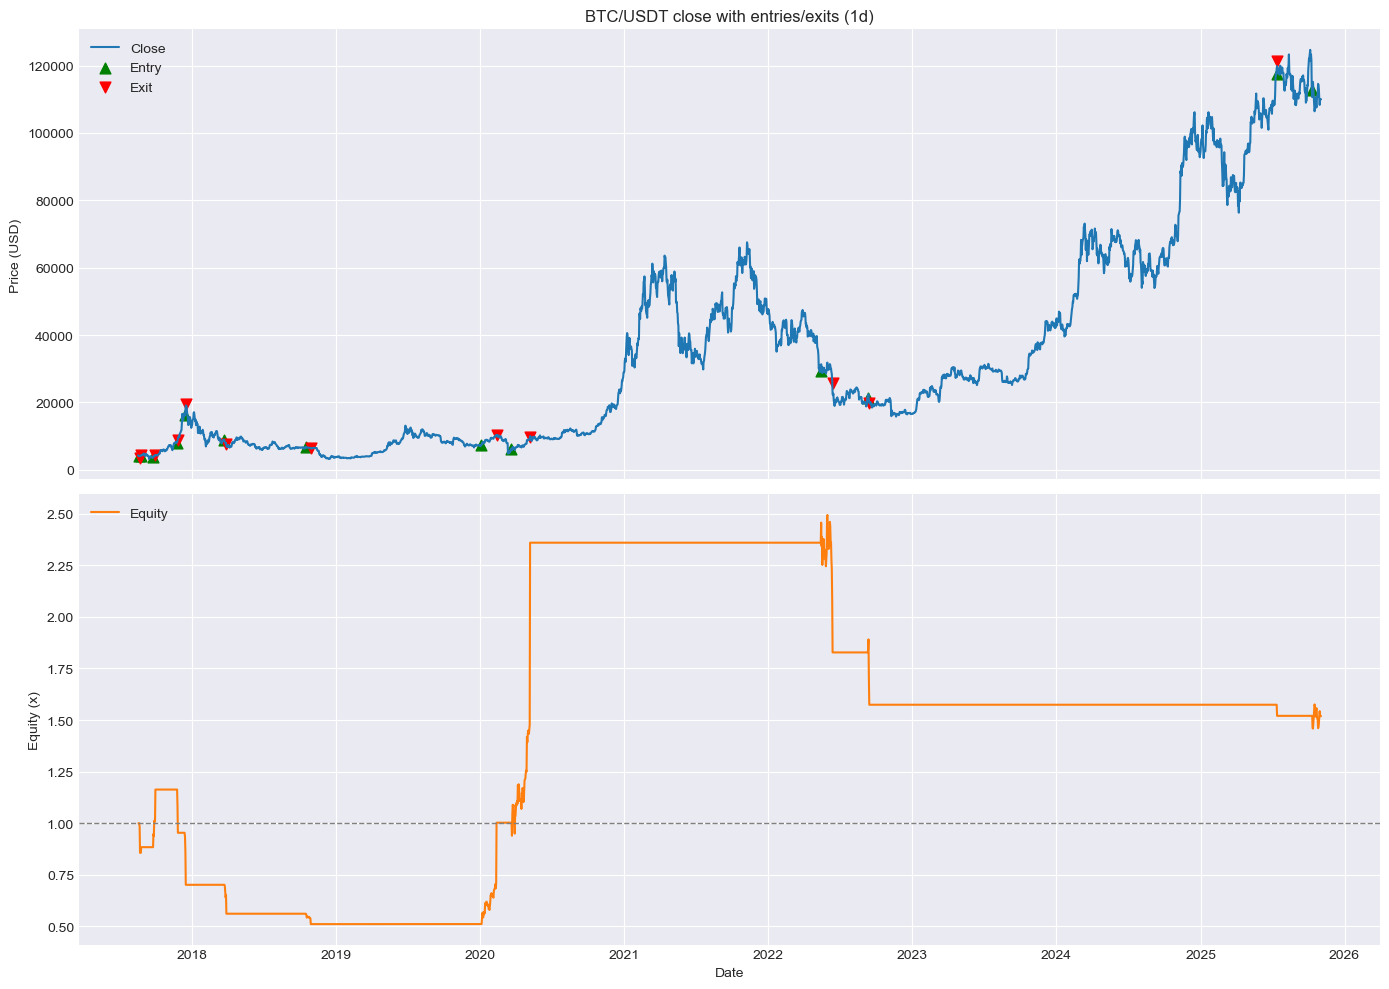

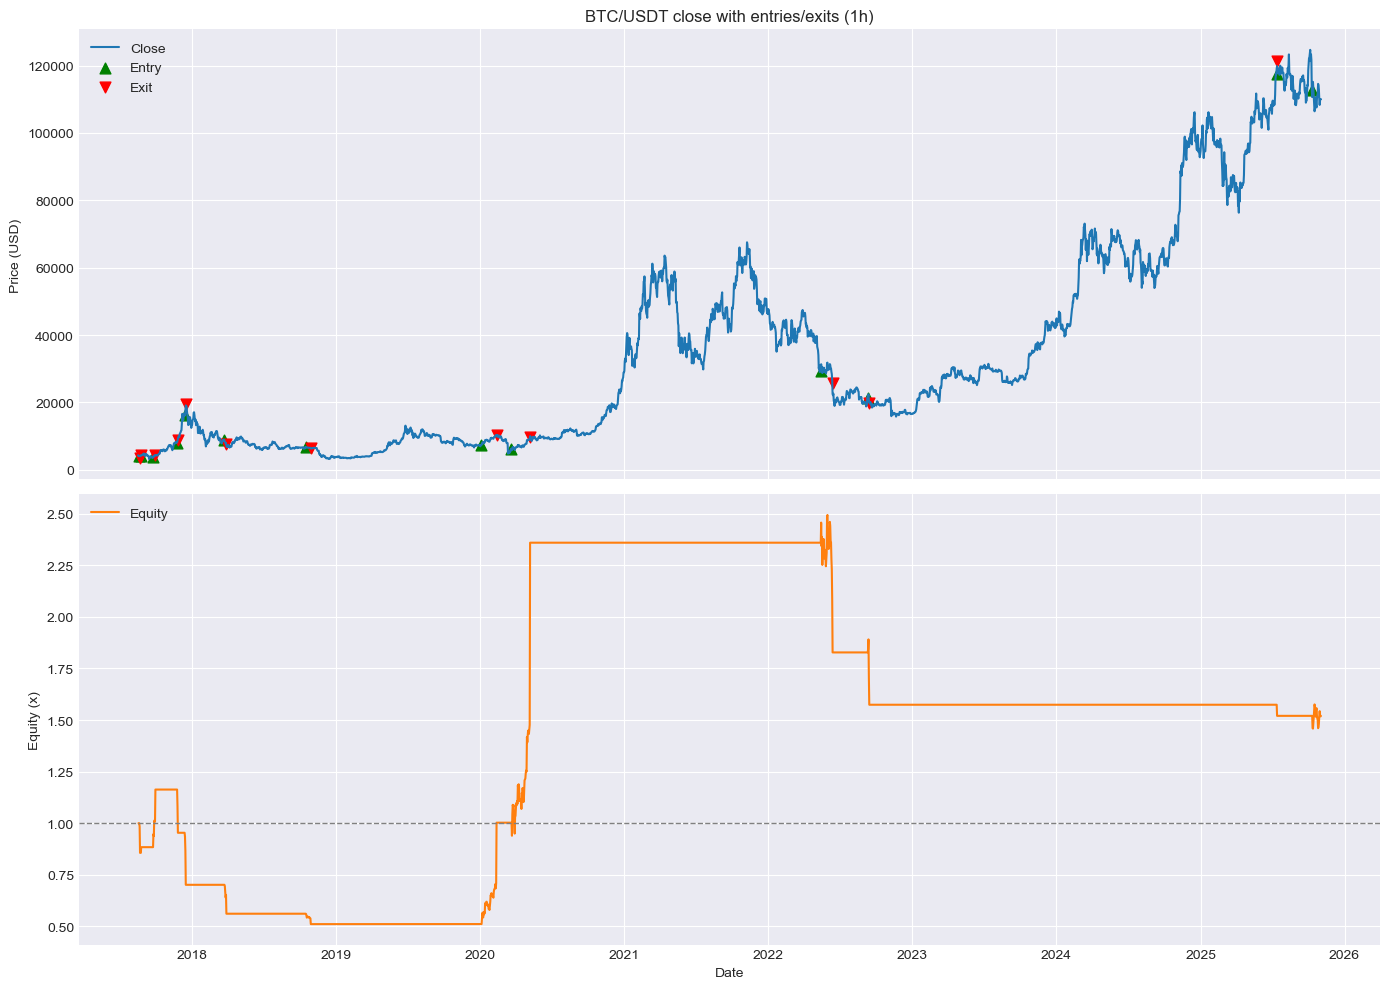

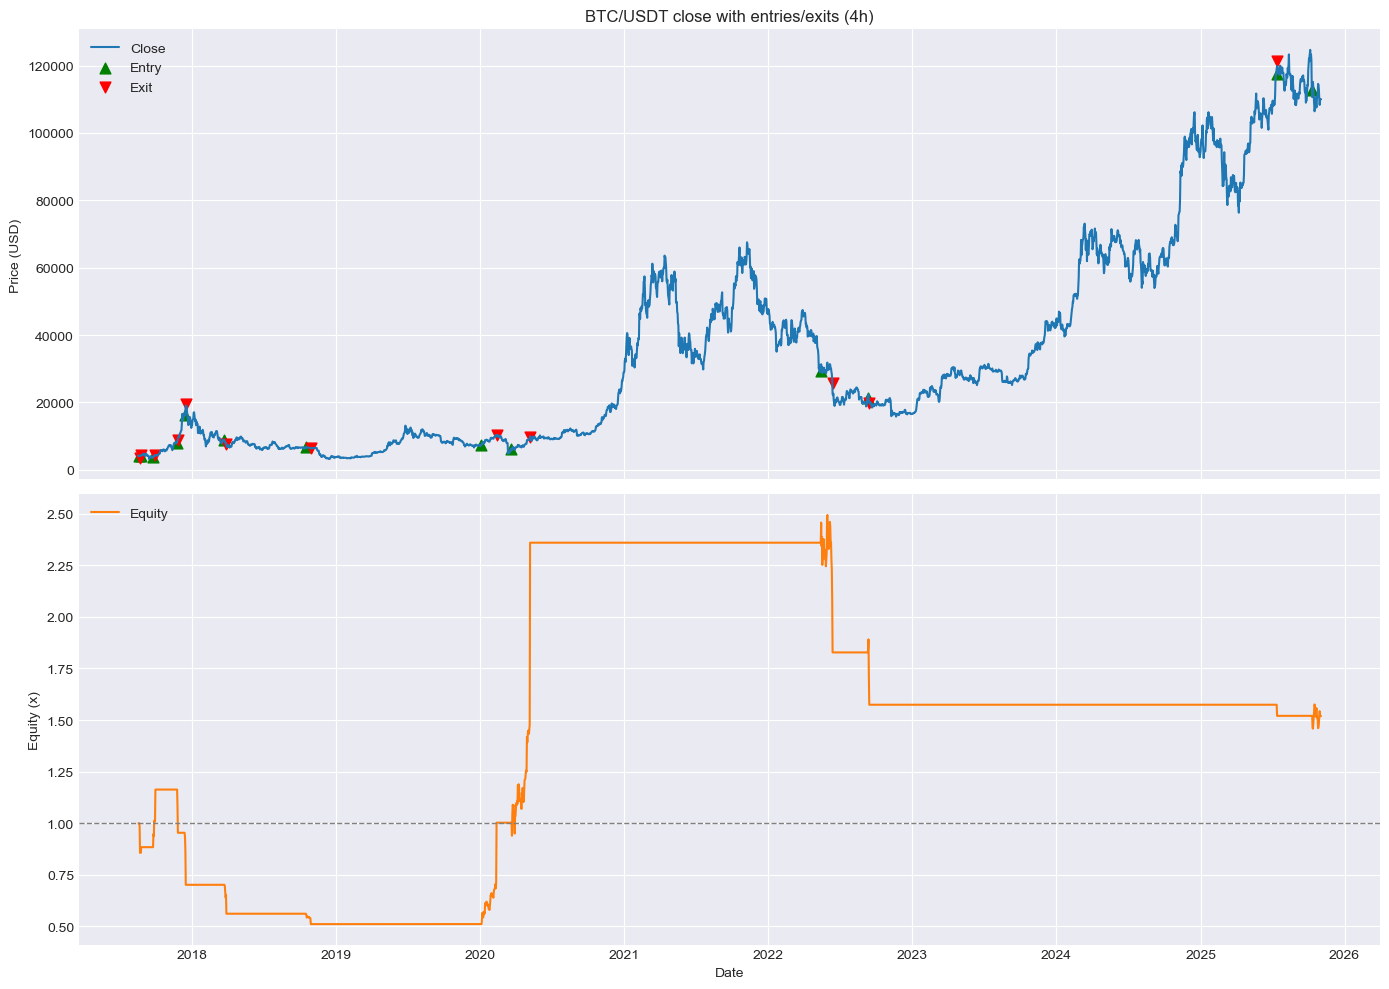

In [ ]:
for tf in timeframes:
    df_tf = frames[tf]
    detail_tf = details[tf]
    fig, (ax_price, ax_eq) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    ax_price.plot(df_tf.index, df_tf['close'], label='Close', color='tab:blue')
    entries = detail_tf[detail_tf['entry_flag'] == 1]
    exits = detail_tf[detail_tf['exit_flag'] == 1]
    if not entries.empty:
        ax_price.scatter(entries.index, entries['entry_price'], marker='^', color='green', s=60, label='Entry')
    if not exits.empty:
        ax_price.scatter(exits.index, exits['exit_price'], marker='v', color='red', s=60, label='Exit')
    ax_price.set_ylabel('Price (USD)')
    ax_price.set_title(f'BTC/USDT close with entries/exits ({tf})')
    ax_price.legend(loc='upper left')
    ax_eq.plot(detail_tf.index, detail_tf['equity'], color='tab:orange', label='Equity')
    ax_eq.axhline(1.0, color='gray', linewidth=1, linestyle='--')
    ax_eq.set_ylabel('Equity (x)')
    ax_eq.set_xlabel('Date')
    ax_eq.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
pd.concat({tf: details[tf][['pos', 'entry_flag', 'exit_flag', 'entry_price', 'exit_price', 'equity']].tail() for tf in timeframes}, axis=0)


pos  entry_flag  exit_flag  entry_price  exit_price    equity
   open_time                                                                
1d 2025-10-29   -1           0          0          NaN         NaN  1.519611
   2025-10-30   -1           0          0          NaN         NaN  1.543070
   2025-10-31   -1           0          0          NaN         NaN  1.524763
   2025-11-01   -1           0          0          NaN         NaN  1.517945
   2025-11-02   -1           0          0          NaN         NaN  1.518815
1h 2025-10-29   -1           0          0          NaN         NaN  1.519611
   2025-10-30   -1           0          0          NaN         NaN  1.543070
   2025-10-31   -1           0          0          NaN         NaN  1.524763
   2025-11-01   -1           0          0          NaN         NaN  1.517945
   2025-11-02   -1           0          0          NaN         NaN  1.518815
4h 2025-10-29   -1           0          0          NaN         NaN  1.519611
   2025-10-30   -1           0          0          NaN         NaN  1.543070
   2025-10-31   -1           0          0          NaN         NaN  1.524763
   2025-11-01   -1           0          0          NaN         NaN  1.517945
   2025-11-02   -1           0          0          NaN         NaN  1.518815